In [1]:
from network import scGen
import scanpy.api as sc
import numpy as np
import wget

In [2]:
path_to_save = "../results"
sc.settings.figdir = path_to_save

Downloading the train and validation data for Kang et al. dataset and datsset from Zheng et al.

In [3]:
train_url = "https://drive.google.com/uc?export=download&id=1NrcbQWiEPj485G3EvGYesqQA3Gom-A0E"
validation_url = "https://drive.google.com/uc?export=download&id=1O8HA0ls-Z6PBpNbxcjFMpg1Wb71sZEGd"
zheng_url = "https://drive.google.com/uc?export=download&id=1BxTiV8XsdV3ewYchxAu-RmdKQB3AJiWN"
t = wget.download(train_url, "../data/train_kang_cross.h5ad")
v = wget.download(validation_url, "../data/valid_kang_cross.h5ad")
z = wget.download(zheng_url, "../data/zheng_control.h5ad")



Reading train, validation from Kang et al. and control cells from Zheng et al.

In [4]:
train =  sc.read("../data/train_kang_cross.h5ad")
validation = sc.read("../data/valid_kang_cross.h5ad")
zheng_control = sc.read("../data/zheng_control.h5ad")

In [5]:
train.X = train.X.A
validation.X = validation.X.A

In [6]:
zheng_control.obs["condition"] = ["control"] *len(zheng_control)

Lets now make scGen object with training, validation and condition labels with training and held out cells

In [7]:
scg = scGen(train,validation, {"ctrl":"control", "stim":"stimulated"}, model_path="../models/cross_study")

We train the model for 150 epochs 

In [7]:
scg.train(150)


----Training----
Model saved in file: models/cross_study
Training finished


Making the predictin for zheng et al. dataset




In [9]:
pred, delta = scg.predict_cross(zheng_control.X.A)


Making one single adata object that contains control and predicted cells

In [10]:
all_Data = sc.AnnData(np.concatenate([zheng_control.X.A,pred]),)
all_Data.obs["condition"] = ["control"] * len(zheng_control.X.A) + ["predicted"] * len(pred)
all_Data.obs["cell_type"]  = zheng_control.obs["cell_type"].tolist() +  zheng_control.obs["cell_type"].tolist()
all_Data.var_names = train.var_names

Now, we visualize control and predicted cells while showing ISG15 expression

In [11]:
sc.pp.neighbors(all_Data)
sc.tl.umap(all_Data)


         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'condition' as categorical
... storing 'cell_type' as categorical
saving figure to file ../results/umap_cross_study_celltype.pdf


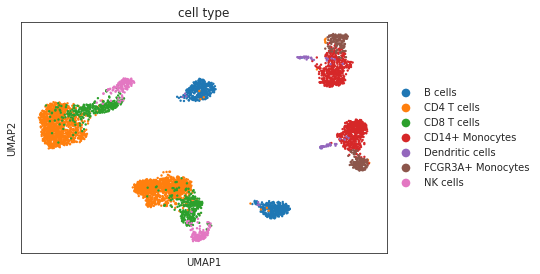

saving figure to file ../results/umap_cross_study_isg15.pdf


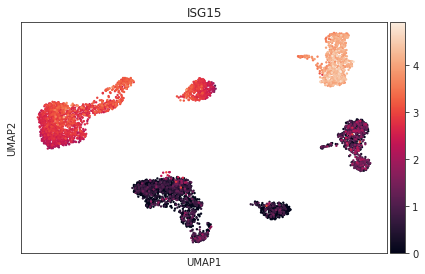

saving figure to file ../results/umap_cross_study_condition.pdf


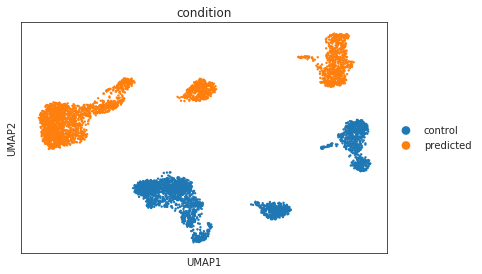

In [12]:
sc.pl.umap(all_Data, color = ["cell_type"], save ="_cross_study_celltype.pdf")
sc.pl.umap(all_Data, color = [ "ISG15"], save ="_cross_study_isg15.pdf")
sc.pl.umap(all_Data, color = ["condition"], save ="_cross_study_condition.pdf")

As shown in the paper now we compare F-Mono cells in different scenarios, first, we show the correlation 
between control and stimulated FCGR3A+ Monocytes (F-Mono) cells from Kang et al. while labeling top 5 DE genes after IFN-beta stimulation 

In [13]:
Fmono_A = train[train.obs["cell_type"] == 'FCGR3A+ Monocytes']
sc.tl.rank_genes_groups(Fmono_A, groupby="condition")
gene_list = Fmono_A.uns["rank_genes_groups"]["names"]["stimulated"][:5]

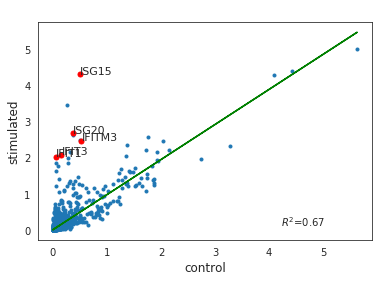

In [14]:
scg.dr.reg_mean_plot_cross(Fmono_A, "../results","Fmono_Kang_cross",
                           gene_list,**{"x":"control","y":"stimulated", "shape":".","line":"g-"})

Now we correlate stimulated F-Mono cells from Kang and control cells from Zheng dataset 

In [15]:
stim_A = Fmono_A[Fmono_A.obs["condition"] == "stimulated"]

In [16]:
zheng_fmono = zheng_control[zheng_control.obs["cell_type"] == 'FCGR3A+ Monocytes']
zheng_fmono.X = zheng_fmono.X.A 

In [17]:
both_stud = stim_A.concatenate(zheng_fmono)

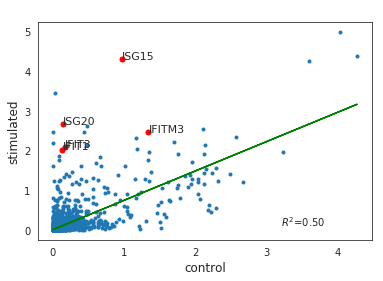

In [18]:
scg.dr.reg_mean_plot_cross(both_stud, "../results","Fmono_Kang_cross_both",
                           gene_list,**{"x":"control","y":"stimulated", "shape":".","line":"g-"})

Finally, we correlate control F-Mono cells from Zheng et al. with our predcitions  

In [19]:
pred = all_Data[all_Data.obs["cell_type"] == 'FCGR3A+ Monocytes']

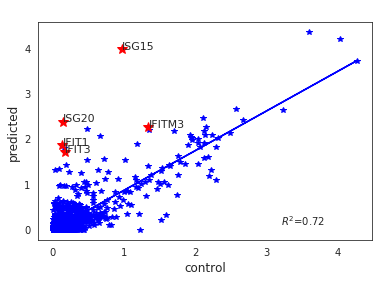

In [20]:
scg.dr.reg_mean_plot_cross(pred, "../results","Fmono_Kang_cross_predict",
                           gene_list,**{"x":"control","y":"predicted", "shape":"b*","line":"b-"})